In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.sparse

/home/sara/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 1) Initialisation

In [2]:
# Paramètres
L = 1
x0 = 0.5
m = 50
x = np.linspace(0,L,m)
b = 1
a = 1
T = 1

In [3]:
def init2(x0,x): #Fonction pour créer un signal carré
    u0 = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < x0:
            u0[i] = 0
        else:
            u0[i] = 1
    return u0

In [4]:
U02 = init2(x0, x)

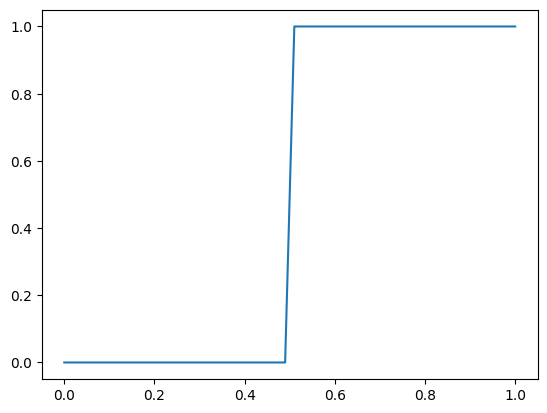

In [5]:
plt.plot(x, U02) # affichage du signal carré

# 2) Schéma d’Euler explicite

## 2.1) FOU

In [6]:
def fou_ee(u0, C, m):
    u = np.zeros(m)
    u[1:m] = u0[1:m] - C*(u0[1:m]-u0[0:m-1])
    u[0] = u[m-1]
    return u

In [7]:
def visu_method_fou_ee(C, U02, window):
    time = 0.0
    U1_fou = fou_ee(U02, C, m)
    dt = C/(m*a)
    while time < T:
        U1_fou = fou_ee(U1_fou, C, m)
        time = time + dt
    plt.subplot(1,3,window)
    plt.plot(x, U02, label = "Signal initial")
    plt.plot(x, U1_fou, label = "Solution")
    plt.legend()
    plt.title("Methode fou_ee, C = " + str(C))

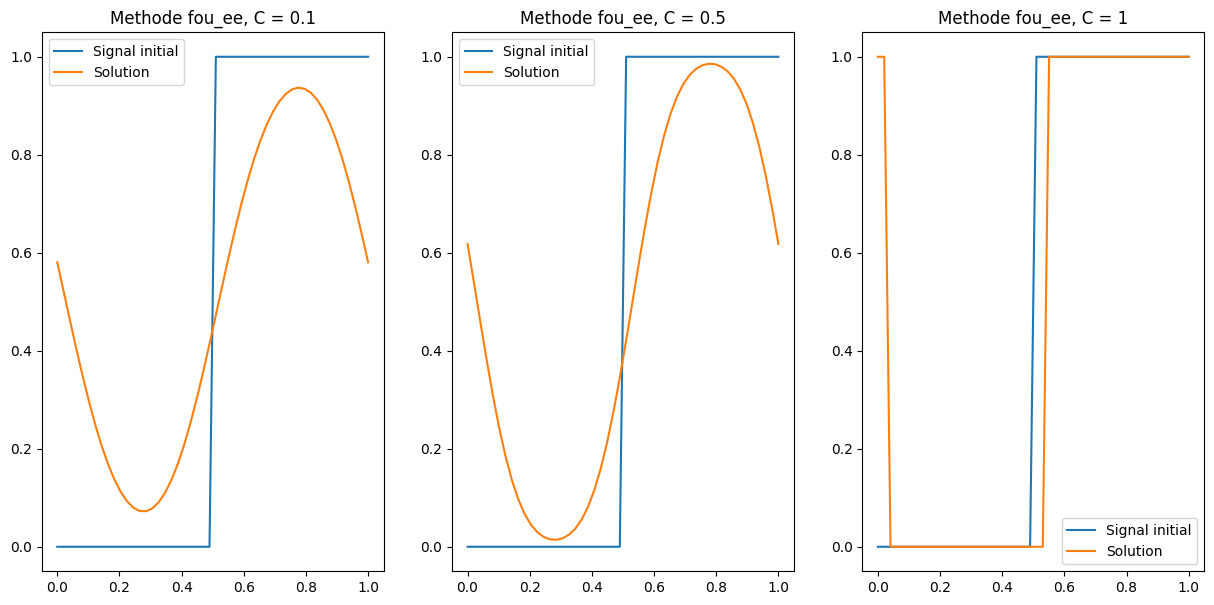

In [8]:
plt.figure(1,figsize=(15,7))
visu_method_fou_ee(0.1, U02, 1)
visu_method_fou_ee(0.5, U02, 2)
visu_method_fou_ee(1, U02, 3)

**Remarque :** Pour la méthode Fou-EE, on observe que plus C est proche de 1, mieux on s'approche du signal initial. On a plus cette effet sinusoïdale. Le schéma a tendance à perdre en amplitude avec des petites valeurs de C.


## 2.2) UPO2VF

In [9]:
def UPO2VF(u0, C, m):
    u = np.zeros(m)
    u[2:m-1] = u0[2:m-1] - C*(u0[3:m]+3*u0[2:m-1]-5*u0[1:m-2]+u0[0:m-3])/4
    u[0] = u0[0] - C/4*(u0[1] + 3*u0[0] -5*u0[m-1] + u0[m-2])
    u[1] = u0[1] - C/4*(u0[2] + 3*u0[1] -5*u0[0] + u0[m-1])
    u[m-1] = u0[m-1] - C/4*(u0[0] + 3*u0[m-1] -5*u0[m-2] + u0[m-3])
    return u

In [10]:
def visu_method_UPO2VF(C, U02, window):
    time = 0.0
    U1_up = UPO2VF(U02, C, m)
    dt = C/(m*a)
    while time < T:
        U1_up = UPO2VF(U1_up, C, m)
        time = time + dt
    plt.subplot(1,3,window)
    plt.plot(x, U02, label = "Signal initial")
    plt.plot(x, U1_up, label = "Solution")
    plt.legend()
    plt.title("Methode UPO2VF, C = " + str(C))

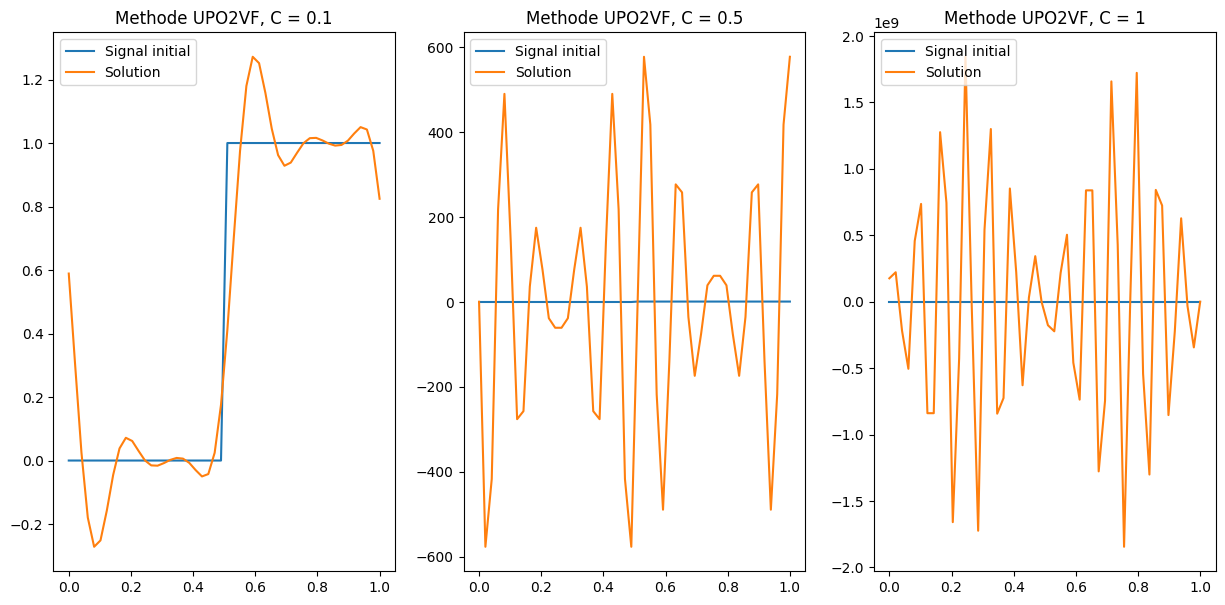

In [11]:
plt.figure(1,figsize=(15,7))
visu_method_UPO2VF(0.1, U02, 1)
visu_method_UPO2VF(0.5, U02, 2)
visu_method_UPO2VF(1, U02, 3)

**Remarque :** Pour ce schéma c'est l'inverse. Il est plus stable pour des petites valeurs de C même si il y a toujours des oscillations. 

# 3) Schéma de Runge-Kutta explicite d'ordre 2

## 3.1) FOU

In [13]:
def rk2_fou(un, m, C):
    du = np.zeros(m)
    u = np.zeros(m)
    u_star = fou_ee(un,C,m)
    du[1:m] = 1/2*((u_star[1:m] - u_star[0:m-1]) + (un[1:m] - un[0:m-1]))
    du[0] = 1/2*((u_star[0] - u_star[-2]) + (un[0] - un[-2]))
    u =  un - C*du
    return u

In [14]:
def visu_method_rk2_fou(beta, C, T, m, window):
    x = np.linspace(0,1,m)
    time = 0.0       
    dt = C/(m*a)
    U1 = rk2_fou(U02,m, C)
    while time<T:
        U1 = rk2_fou(U1,m,C)
        time = time + dt
    plt.subplot(1,3,window)
    plt.plot(x, U02, label="Signal initial")
    plt.plot(x, U1, label="Solution") 
    plt.legend()
    plt.title("Methode rk2 + FOU, C = " + str(C))

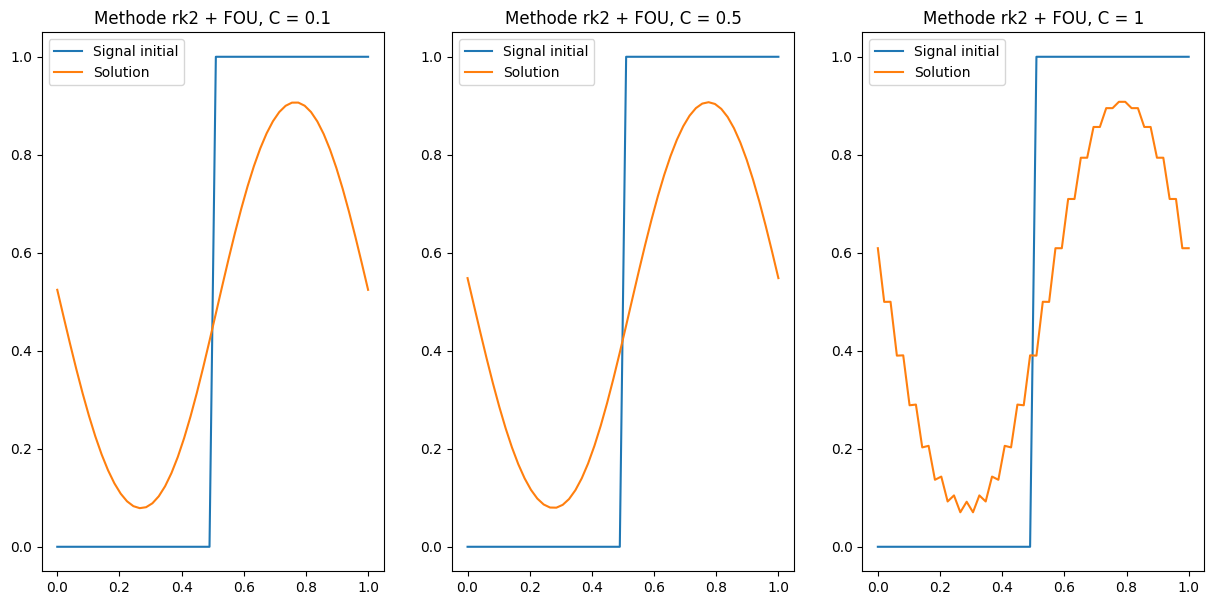

In [15]:
plt.figure(1,figsize=(15,7))
visu_method_rk2_fou(1,0.1,T,m,1)
visu_method_rk2_fou(1,0.5,T,m,2)
visu_method_rk2_fou(1,1,T,m,3)

**Remarque :** Lorsqu'on associe RK2 et FOU, il n'y a pas de différence en terme d'amplitude ou de déphasage en fonction de C. L'effet se voit sur la "lisseure" de notre solution. En effet pour C = 1, on a un effet de cran comme si notre sinus est segmenté.

## 3.2) UPO2VF

In [16]:
def rk2_upo2v(un, m, C):
    du = np.zeros(m)
    u = np.zeros(m)
    u_star = UPO2VF(un, C, m)
    du[2:m-1] = (u_star[3:m]+3*u_star[2:m-1]-5*u_star[1:m-2]+u_star[0:m-3])/8 + (un[3:m]+3*un[2:m-1]-5*un[1:m-2]+un[0:m-3])/8
    du[0] = (u_star[1] + 3*u_star[0] -5*u_star[m-1] + u_star[m-2])/8 + (un[1] + 3*un[0] -5*un[m-1] + un[m-2])/8
    du[1] = (u_star[2] + 3*u_star[1] -5*u_star[0] + u_star[m-1])/8 + (un[2] + 3*un[1] -5*un[0] + un[m-1])/8
    du[m-1] = (u_star[0] + 3*u_star[m-1] -5*u_star[m-2] + u_star[m-3])/8 + (un[0] + 3*un[m-1] -5*un[m-2] + un[m-3])/8
    u =  un - C*du
    return u

In [18]:
def visu_method_rk2_upo2v(beta, C, T, m, window):
    x = np.linspace(0,1,m)
    time = 0.0       
    dt = C/(m*a)
    U1 = rk2_upo2v(U02,m, C)
    while time<T:
        U1 = rk2_upo2v(U1,m, C)
        time = time + dt
    plt.subplot(1,3,window)
    plt.plot(x, U02, label="Signal initial")
    plt.plot(x, U1, label="Solution") 
    plt.legend()
    plt.title("Methode rk2 + UPO2V, C = " + str(C))

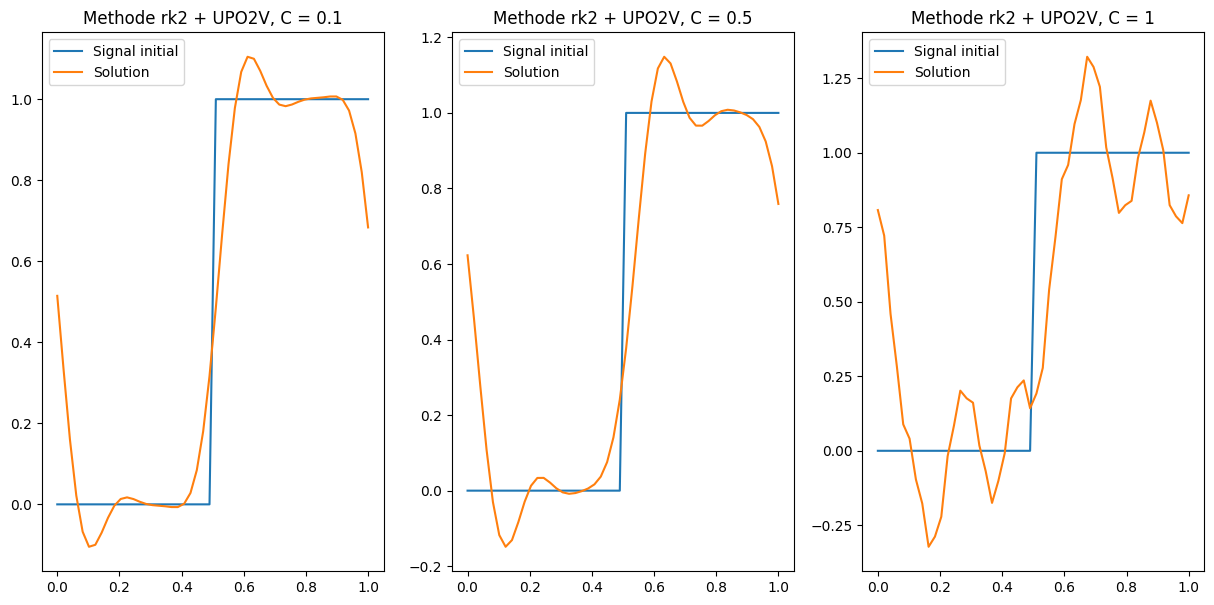

In [19]:
plt.figure(1,figsize=(15,7))
visu_method_rk2_upo2v(1,0.1,T,m,1)
visu_method_rk2_upo2v(1,0.5,T,m,2)
visu_method_rk2_upo2v(1,1,T,m,3)

**Remarque :** Dans ce cas là, on remarque le changement au niveau de l'amplitude des oscillations. Plus on a un C petit moins on diverge. 

# 4) Euler implicite

## 4.1) FOU

In [20]:
def fou_ei(U02, C, m, T, a):
    dt = C / (m * a)
    num_steps = int(T / dt)
    u = np.zeros((num_steps, m))
    u[0, :] = U02
    mat = scipy.sparse.diags([1+C, -C], [0,-1], shape=(m,m), format = 'lil')
    mat[0,-1] = -C
    for k in range(0, num_steps-1):
        u[k+1, :] = np.linalg.solve(mat.toarray(), u[k, :])
    return u[-1, :]

In [21]:
def visu_method_fou_ei(C, U02, m, T, a, x, window):
    U1_fou_euler = fou_ei(U02, C, m, T, a)
    plt.subplot(2, 3, window)
    plt.plot(x, U02, label="Signal initial")
    plt.plot(x, U1_fou_euler, label="Solution")
    plt.legend()
    plt.title("Euler implicite + FOU, C = " + str(C))

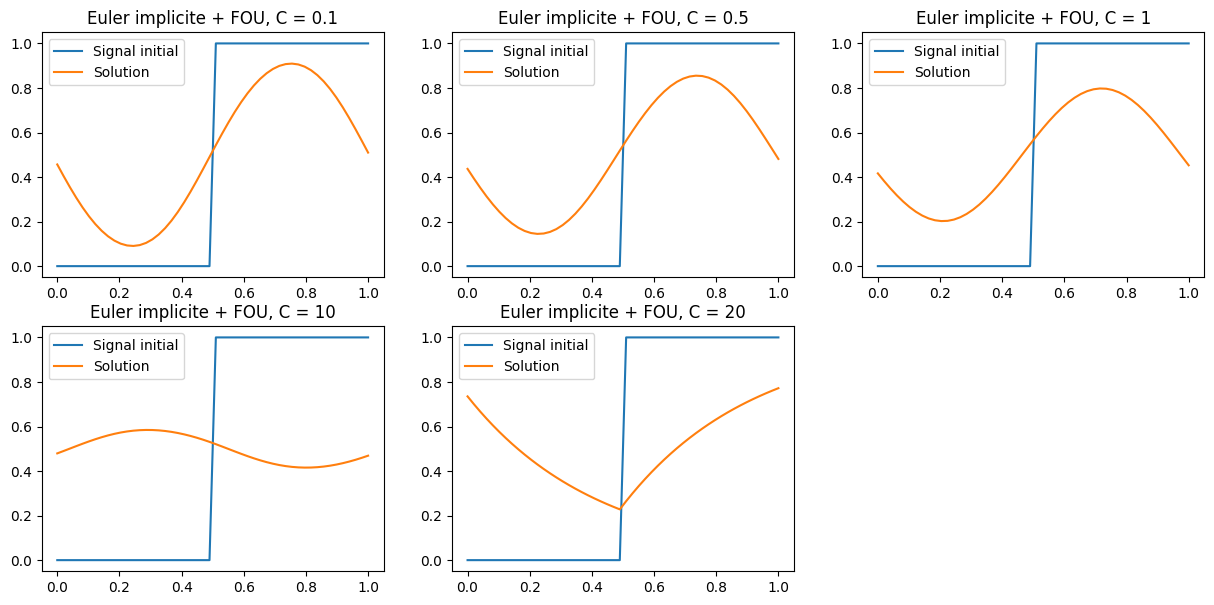

In [22]:
plt.figure(1,figsize=(15,7))
visu_method_fou_ei(0.1, U02, m, T, a, x, 1)
visu_method_fou_ei(0.5, U02, m, T, a, x, 2)
visu_method_fou_ei(1, U02, m, T, a, x, 3)
visu_method_fou_ei(10, U02, m, T, a, x, 4)
visu_method_fou_ei(20, U02, m, T, a, x, 5)

**Remarque :** Le schéma Fou-EI n'est pas adapté au signal carré. Pour des petites valeurs de C, on obtient un sinus qui ne colle pas au signal initial. Puis plus C augmente plus on perd notre forme de sinus.

## 4.2) UPO2VF

In [23]:
def upo2vf_ei(U02, C, m, T, a):
    dt = C / (m * a)
    num_steps = int(T / dt)
    u = np.zeros((num_steps, m))
    u[0, :] = U02
    mat = scipy.sparse.diags([C/4, -5*C/4, 1 + 3*C/4, C/4], [-2, -1, 0, 1], shape=(m,m), format = 'lil')
    mat[0,-1] = -5*C/4
    mat[0,-2] = C/4
    mat[-1,0] = C/4
    mat[1,-1] = C/4

    for k in range(0, num_steps-1):
        u[k+1, :] = np.linalg.solve(mat.toarray(), u[k, :])
    return u[-1, :]

In [24]:
def visu_method_upo2vf_ei(C, U02, m, T, a, x, window):
    U1_upo2vf_ei= upo2vf_ei(U02, C, m, T, a)
    plt.subplot(2, 3, window)
    plt.plot(x, U02, label="Signal initial")
    plt.plot(x, U1_upo2vf_ei, label="Solution")
    plt.legend()
    plt.title("Euler implicite + UPO2VF, C = " + str(C))

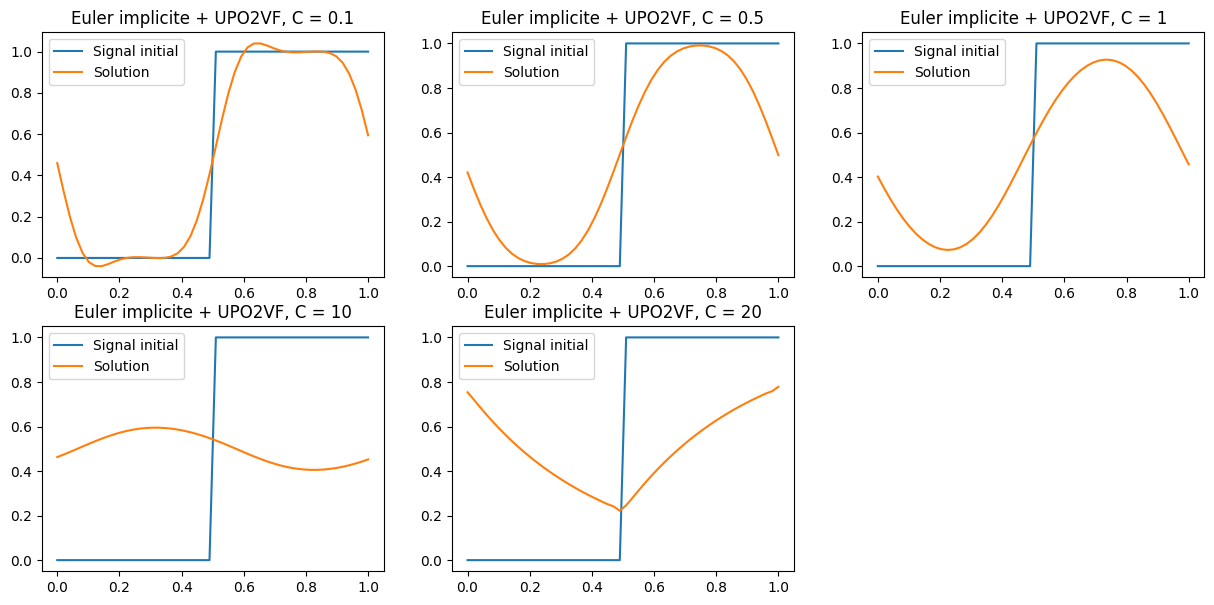

In [25]:
plt.figure(1,figsize=(15,7))
visu_method_upo2vf_ei(0.1, U02, m, T, a, x, 1)
visu_method_upo2vf_ei(0.5, U02, m, T, a, x, 2)
visu_method_upo2vf_ei(1, U02, m, T, a, x, 3)
visu_method_upo2vf_ei(10, U02, m, T, a, x, 4)
visu_method_upo2vf_ei(20, U02, m, T, a, x, 5)

**Remarque :** Pour des petites valeurs de C, on arrive à s'approcher de notre signal carré avec un dépassement. Puis lorsque C augmente, l'amplitude décroit jusqu'à avoir un signal applatit pour C = 10. Et pour C = 20, nous obtenons une solution très éloignée de notre signal initial.